In [1]:
import numpy as np

# ----- Generate data -----
np.random.seed(0)
N, D = 100, 3
X = np.random.randn(N, D)
true_w = np.array([2.0, -3.0, 1.0])
y = X @ true_w + 0.5 * np.random.randn(N)

# ----- Adam optimizer -----
def adam_optimizer(X, y, lr=0.05, beta1=0.9, beta2=0.999, eps=1e-8,
                   epochs=200, batch_size=10, grad_noise=0.0):
    N, D = X.shape
    w = np.zeros(D)
    m = np.zeros(D)
    v = np.zeros(D)

    for t in range(1, epochs + 1):
        # Shuffle data
        idx = np.random.permutation(N)
        X, y = X[idx], y[idx]

        for i in range(0, N, batch_size):
            Xb = X[i:i+batch_size]
            yb = y[i:i+batch_size]

            # Compute gradient
            grad = (Xb.T @ (Xb @ w - yb)) / len(yb)

            # Add artificial noise
            grad += grad_noise * np.random.randn(*grad.shape)

            # Adam updates
            m = beta1 * m + (1 - beta1) * grad
            v = beta2 * v + (1 - beta2) * (grad ** 2)

            m_hat = m / (1 - beta1 ** t)
            v_hat = v / (1 - beta2 ** t)

            w -= lr * m_hat / (np.sqrt(v_hat) + eps)

    return w

# ----- Run experiments -----
for noise_level in [0.0, 0.1, 0.5]:
    w_est = adam_optimizer(X, y, grad_noise=noise_level)
    mse = np.mean((X @ w_est - y) ** 2)
    print(f"Gradient noise {noise_level:>4}:  Estimated w = {w_est},  MSE = {mse:.4f}")


Gradient noise  0.0:  Estimated w = [ 1.97402597 -3.03236328  1.02144662],  MSE = 0.2227
Gradient noise  0.1:  Estimated w = [ 1.9479948  -3.03065394  1.05706508],  MSE = 0.2235
Gradient noise  0.5:  Estimated w = [ 1.90850151 -3.13235842  1.12397901],  MSE = 0.2423


In [ ]:
import numpy as np

# ----- Generate nonlinear data -----
np.random.seed(0)
N = 200
x = np.linspace(-3, 3, N)
true_w = np.array([1.0, 0.0])  # y = 1*x^2 + 0
y = true_w[0] * x**2 + true_w[1] + 0.5 * np.random.randn(N)  # add observation noise

# Model: y_pred = w0*x^2 + w1
def predict(w, x):
    return w[0] * x**2 + w[1]

# Compute gradient of loss (1/2N sum (y_pred - y)^2)
def grad_f(w, x, y):
    y_pred = predict(w, x)
    error = y_pred - y
    grad0 = np.mean(error * x**2)   # ∂/∂w0
    grad1 = np.mean(error)          # ∂/∂w1
    return np.array([grad0, grad1])

# ----- Adam optimizer -----
def adam_optimizer(x, y, lr=0.05, beta1=0.9, beta2=0.999, eps=1e-8,
                   epochs=200, grad_noise=0.0):
    w = np.zeros(2)
    m = np.zeros_like(w)
    v = np.zeros_like(w)

    for t in range(1, epochs + 1):
        grad = grad_f(w, x, y)

        # Add artificial gradient noise
        grad += grad_noise * np.random.randn(*grad.shape)

        # Adam updates
        m = beta1 * m + (1 - beta1) * grad
        v = beta2 * v + (1 - beta2) * (grad ** 2)
        m_hat = m / (1 - beta1 ** t)
        v_hat = v / (1 - beta2 ** t)
        w -= lr * m_hat / (np.sqrt(v_hat) + eps)

    return w

# ----- Run experiments -----
for noise_level in [0.0, 0.1, 0.5]:
    w_est = adam_optimizer(x, y, grad_noise=noise_level, epochs=300)
    mse = np.mean((predict(w_est, x) - y)**2)
    print(f"Gradient noise {noise_level:>4}:  Estimated w = {w_est},  MSE = {mse:.4f}")


Gradient noise  0.0:  Estimated w = [1.00476673 0.02101195],  MSE = 0.2607
Gradient noise  0.1:  Estimated w = [ 1.01512145 -0.03542462],  MSE = 0.2621
Gradient noise  0.5:  Estimated w = [1.00208295 0.06195511],  MSE = 0.2618


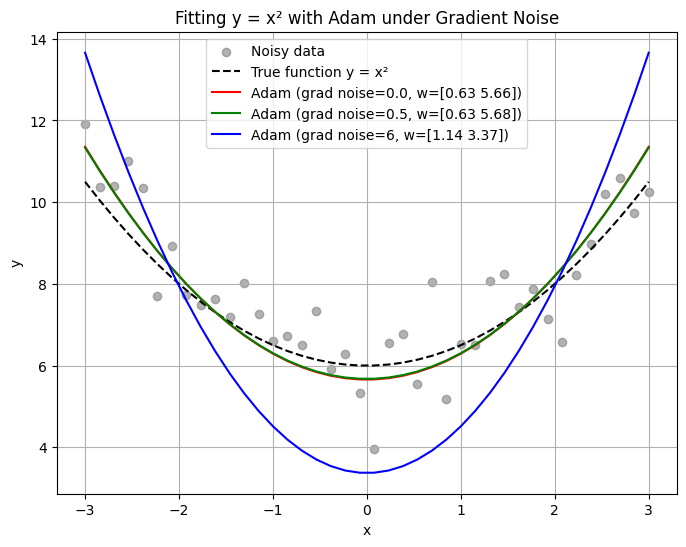

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# ----- Generate nonlinear data -----
np.random.seed(0)
N = 40
x = np.linspace(-3, 3, N)
true_w = np.array([0.5, 6.0])  # true model: y = 5*x^2 + 6
y = true_w[0] * x**2 + true_w[1] + 0.8 * np.random.randn(N)  # add measurement noise

# Model: y_pred = w0*x^2 + w1
def predict(w, x):
    return w[0] * x**2 + w[1]

# Gradient of loss (1/2N * sum (y_pred - y)^2)
def grad_f(w, x, y):
    y_pred = predict(w, x)
    error = y_pred - y
    grad0 = np.mean(error * x**2)
    grad1 = np.mean(error)
    return np.array([grad0, grad1])

# Adam optimizer
def adam_optimizer(x, y, lr=0.05, beta1=0.9, beta2=0.999, eps=1e-8,
                   epochs=300, grad_noise=0.0):
    w = np.zeros(2)
    m = np.zeros_like(w)
    v = np.zeros_like(w)
    for t in range(1, epochs + 1):
        grad = grad_f(w, x, y)
        grad += grad_noise * np.random.randn(*grad.shape)
        m = beta1 * m + (1 - beta1) * grad
        v = beta2 * v + (1 - beta2) * (grad ** 2)
        m_hat = m / (1 - beta1 ** t)
        v_hat = v / (1 - beta2 ** t)
        w -= lr * m_hat / (np.sqrt(v_hat) + eps)
    return w

# ----- Run experiments -----
noise_levels = [0.0, 0.5, 6]
colors = ['r', 'g', 'b']

plt.figure(figsize=(8, 6))
plt.scatter(x, y, color='gray', alpha=0.6, label='Noisy data')
plt.plot(x, true_w[0] * x**2 + true_w[1], 'k--', label='True function y = x²')

for noise_level, color in zip(noise_levels, colors):
    w_est = adam_optimizer(x, y, grad_noise=noise_level)
    y_pred = predict(w_est, x)
    plt.plot(x, y_pred, color=color,
             label=f'Adam (grad noise={noise_level}, w={w_est.round(2)})')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Fitting y = x² with Adam under Gradient Noise')
plt.legend()
plt.grid(True)
plt.show()


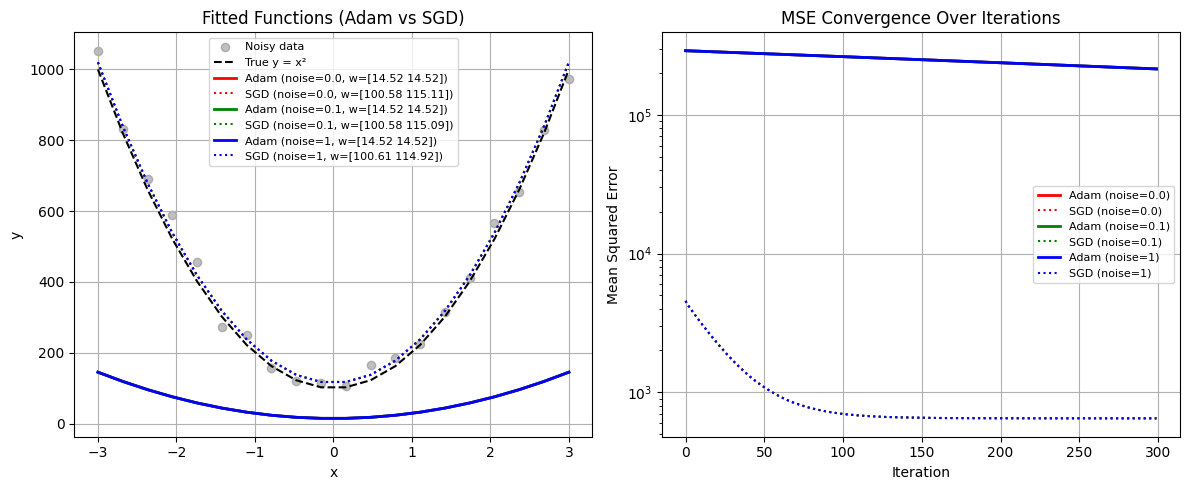

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# ----- Generate nonlinear data -----
np.random.seed(0)
N = 20
x = np.linspace(-3, 3, N)
true_w = np.array([100, 100])  # true model: y = x²
y = true_w[0] * x**2 + true_w[1] + 30 * np.random.randn(N)  # noisy observations

# Model: y_pred = w0*x^2 + w1
def predict(w, x):
    return w[0] * x**2 + w[1]

# Gradient of loss (1/2N * sum (y_pred - y)^2)
def grad_f(w, x, y):
    y_pred = predict(w, x)
    error = y_pred - y
    grad0 = np.mean(error * x**2)
    grad1 = np.mean(error)
    return np.array([grad0, grad1])

# Compute MSE
def mse_loss(w, x, y):
    return np.mean((predict(w, x) - y) ** 2)

# ----- Adam optimizer -----
def adam_optimizer(x, y, lr=0.05, beta1=0.9, beta2=0.999, eps=1e-8,
                   epochs=300, grad_noise=0.0):
    w = np.zeros(2)
    m = np.zeros_like(w)
    v = np.zeros_like(w)
    losses = []
    for t in range(1, epochs + 1):
        grad = grad_f(w, x, y)
        grad += grad_noise * np.random.randn(*grad.shape)
        # Adam update
        m = beta1 * m + (1 - beta1) * grad
        v = beta2 * v + (1 - beta2) * (grad ** 2)
        m_hat = m / (1 - beta1 ** t)
        v_hat = v / (1 - beta2 ** t)
        w -= lr * m_hat / (np.sqrt(v_hat) + eps)
        losses.append(mse_loss(w, x, y))
    return w, np.array(losses)

# ----- Regular SGD optimizer -----
def sgd_optimizer(x, y, lr=0.05, epochs=300, grad_noise=0.0):
    w = np.zeros(2)
    losses = []
    for t in range(1, epochs + 1):
        grad = grad_f(w, x, y)
        grad += grad_noise * np.random.randn(*grad.shape)
        w -= lr * grad
        losses.append(mse_loss(w, x, y))
    return w, np.array(losses)

# ----- Run experiments -----
noise_levels = [0.0, 0.1, 1]
colors = ['r', 'g', 'b']

adam_fits, sgd_fits = [], []
adam_losses, sgd_losses = [], []

for nl in noise_levels:
    w_adam, loss_adam = adam_optimizer(x, y, grad_noise=nl)
    w_sgd, loss_sgd = sgd_optimizer(x, y, grad_noise=nl)
    adam_fits.append((nl, w_adam))
    sgd_fits.append((nl, w_sgd))
    adam_losses.append((nl, loss_adam))
    sgd_losses.append((nl, loss_sgd))

# ----- Plot results -----
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# (1) Function fits
axes[0].scatter(x, y, color='gray', alpha=0.5, label='Noisy data')
axes[0].plot(x, true_w[0] * x**2 + true_w[1], 'k--', label='True y = x²')

for (nl, w_adam), (nl2, w_sgd), color in zip(adam_fits, sgd_fits, colors):
    axes[0].plot(x, predict(w_adam, x), color=color, lw=2,
                 label=f'Adam (noise={nl}, w={w_adam.round(2)})')
    axes[0].plot(x, predict(w_sgd, x), color=color, ls=':',
                 label=f'SGD (noise={nl}, w={w_sgd.round(2)})')

axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].set_title('Fitted Functions (Adam vs SGD)')
axes[0].legend(fontsize=8)
axes[0].grid(True)

# (2) MSE convergence
for (nl, loss_adam), (nl2, loss_sgd), color in zip(adam_losses, sgd_losses, colors):
    axes[1].plot(loss_adam, color=color, lw=2, label=f'Adam (noise={nl})')
    axes[1].plot(loss_sgd, color=color, ls=':', label=f'SGD (noise={nl})')

axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Mean Squared Error')
axes[1].set_title('MSE Convergence Over Iterations')
axes[1].set_yscale('log')
axes[1].legend(fontsize=8)
axes[1].grid(True)

plt.tight_layout()
plt.show()
